In [2]:
from pymongo import MongoClient
from sys import getsizeof
import numpy as np 
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from sympy import degree
from tqdm import tqdm
import math
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import linregress
import powerlaw as plw
import datetime
from reddit import plotting
from reddit import datahandling as dh
%load_ext autoreload
%autoreload 2

In [5]:
topsubreddits = np.array([['funny', 40905607],
['AskReddit', 36019222],
['gaming', 33015877],
['aww', 31271221],
['Music', 29768958],
['pics', 29021790],
['worldnews', 28941680],
['movies', 28039861],
['todayilearned', 27747583],
['science', 27575625],
['videos', 26451270],
['Showerthoughts', 24810152],
['news', 24746886],
['Jokes', 23229845],
['askscience', 22558386],
['food', 22543841],
['EarthPorn', 22109039],
['IAmA', 22058298],
['gifs', 21468949],
['nottheonion', 21435088],
['DIY', 20992074],
['books', 20946621],
['Art', 20720646],
['explainlikeimfive', 20670053],
['LifeProTips', 20626939],
['space', 20478188],
['sports', 20228436],
['mildlyinteresting', 19996396],
['gadgets', 19845412],
['Documentaries', 19839298],
['memes', 19132045],
['UpliftingNews', 17990001],
['photoshopbattles', 17980451],
['tifu', 17973168],
['dataisbeautiful', 17871549],
['GetMotivated', 17843984],
['listentothis', 17210600],
['history', 16809204],
['philosophy', 16694671],
['television', 16459136],
['Futurology', 16197070],
#['InternetIsBeautiful', 16135050],
['OldSchoolCool', 16083854],
['WritingPrompts', 15959980],
['personalfinance', 15895757],
['nosleep', 15865653],
['creepy', 14586923],
['TwoXChromosomes', 13362358],
['wallstreetbets', 12202846],
['technology', 12112469],
['wholesomememes', 11519505],
['interestingasfuck', 9740639],
['Fitness', 9629483],
['AdviceAnimals', 9496829],
['politics', 8067612],
['lifehacks', 7371997],
['oddlysatisfying', 6960025],
['NatureIsFuckingLit', 6894659],
['relationship_advice', 6819315],
['WTF', 6816059],
['Minecraft', 6582284],
['travel', 6532908],
['Unexpected', 6325804],
['facepalm', 6288288],
['Whatcouldgowrong', 6258903],
['nextfuckinglevel', 6254913],
['pcmasterrace', 6148774],
['leagueoflegends', 5862708],
['me_irl', 5840842],
['dadjokes', 5798141],
['buildapc', 5706187],
['dankmemes', 5653670],
['BlackPeopleTwitter', 5553816],
['MadeMeSmile', 5547749],
['PS4', 5428167],
['Tinder', 5367307],
['bestof', 5351502],
['AnimalsBeingBros', 5330736],
['Damnthatsinteresting', 5120136],
['AnimalsBeingDerps', 5053525],
['CryptoCurrency', 4948177],
['tattoos', 4868803],
['AnimalsBeingJerks', 4834586],
['nba', 4817859],
['photography', 4721144],
['gardening', 4600794],
['Parenting', 4331225],
['WatchPeopleDieInside', 4312204],
['mildlyinfuriating', 4298792],
['Awwducational', 4257822],
['HistoryMemes', 4257244],
['Bitcoin', 4253999],
['anime', 4238587],
['malefashionadvice', 4232348],
['FoodPorn', 4222787],
['programming', 4218024],
['BikiniBottomTwitter', 4215662],
['trippinthroughtime', 4196051],
['EatCheapAndHealthy', 4187234],
['woodworking', 412461]])

In [3]:
#networkx graph design
options = {
    #'node_color': 'red',
    'node_size': 1,
    'width': 0.2,
    'arrowsize': 2
}

In [4]:
## ToDo: export to library
def getTop(top, sortby = None):
    if sortby is None:
        raise NameError('No argument to sort by')
    pipe = [
        {'$sort': {sortby:-1}},
        {'$limit': top},
        {'$project': {'_id':1}}
    ]
    statdb = client.reddit_statistics
    collection = statdb.subreddit_submissions
    cursor = collection.aggregate(pipe)
    df = pd.DataFrame(list(cursor))
    df_array = df.to_numpy()
    return(df_array)

def getTopNum(top, sortby = None):
    if sortby is None:
        raise NameError('No argument to sort by')
    pipe = [
        {'$sort': {sortby:-1}},
        {'$limit': top},
        {'$project': {'comments':1, '_id': -1}}
    ]
    statdb = client.reddit_statistics
    collection = statdb.subreddit_submissions
    cursor = collection.aggregate(pipe)
    df = pd.DataFrame(list(cursor))
    df_array = df.to_numpy()
    return(df_array)


In [39]:
test = getTopNum(100, 'comments')

In [12]:
client = MongoClient('localhost', 27017)
db = client.reddit
start = 1577836800
end = 1580515200

def genDirNet(data, ):
    G = nx.MultiDiGraph()
    num_users = data.shape[0]
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    return G

def getPipeline(subreddit, start, end, limit=100000):
    pipeline = [
        {'$project': {'_id': 0, 'link_id':0, 'score':0}},#  'id': 1, 'subreddit': 1, 'parent_id': 1, 'author': 1}}, 
        {'$match': {'subreddit': subreddit,'created_utc':{ '$gt': start, '$lt': end },'author': {'$ne': '[deleted]'}}},
        #{'$limit': limit},
        {'$project': {'subreddit': 0}},
        {'$sort': {'id':1}}
    ]
    return pipeline

def getDataframe(db, subreddit, start, end, which='both'):
    """
	Loads data from given subreddit from database and packs into dataframe
	Args:
		subreddit:
		start:
		end:
        which: 
	Returns:
        Dataframe for given parameters
	"""
    ### Load Database and apply pipeline, assign unique index to each user
    if which != 'both':
        collection = db[which]
        cursor = collection.aggregate(getPipeline(str(subreddit),start,end),allowDiskUse=True )
        #cursor = collection.find({'subreddit':subreddit}).hint('Interactions')
        df = pd.DataFrame(list(cursor))
        df.drop(columns=['subreddit','score', 'link_id','_id','created_utc','num_comments','domain'], errors='ignore', inplace=True)
        if which == 'submissions':
            df.insert(2, 'parent_id', '')

    else:
        df_sub = getDataframe(subreddit, which='submissions')
        df_com = getDataframe(subreddit,which='comments')
        df = pd.concat([df_sub,df_com])
    df['id'] = df['id'].astype('string') 
    df['parent_id'] = df['parent_id'].astype('string').str.replace('t3_','')
    df['parent_id'] = df['parent_id'].astype('string').str.replace('t1_','')
    return df
    
def getMyParents(df):
    """
	Args:
		df:
	Returns:
        numpy array with parent user id
	"""
    df['user_id'] = df.groupby('author').ngroup()    ##Add user id
    df['parent_user_id'] = pd.Series(dtype=int)
    df = df.assign(parent_user_id = -1)
    df_array = df.to_numpy()
    del(df)
    for i,li in tqdm(enumerate(df_array[:,2])): #iterate over posts link id
        pos = np.searchsorted(df_array[:,1],li)
        if pos != df_array.shape[0]:
            if li == df_array[pos,1]:
                df_array[i,4] = df_array[pos,3]
    return df_array

def getData(db,subreddit,start,end,which,save=True):
    try:
        data = np.load('./top100/first10000/{}_2020.npy'.format(subreddit), allow_pickle=True)
    except:
        print('Subreddit not analyzed yet. Generating new array. This may take a while...')
        df = getDataframe(db,subreddit,start,end,'comments')
        data = getMyParents(df)
        del(df)
        if save:
            np.save('./top100/first100000/{}_2020.npy'.format(subreddit), data)
    return data

def getUTC(date):
    return date.replace(tzinfo=datetime.timezone.utc).timestamp()

In [5]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

1it [00:00,  1.35it/s]

Subreddit: ['AskReddit'], Top 3 outlier authors: ['Bacon_Warrior' 'Dontaskatall' 'AutoModerator']


2it [00:01,  1.18it/s]

Subreddit: ['politics'], Top 3 outlier authors: ['Mahasamatman3' 'checker280' 'RedMethodKB']


3it [00:02,  1.14it/s]

Subreddit: ['funny'], Top 3 outlier authors: ['blackarmchair' 'wooliewookies' 'vidyabalachander']


4it [00:03,  1.14it/s]

Subreddit: ['pics'], Top 3 outlier authors: ['JosephMcN' 'Wasted_Penguinz' 'Dick6576']


5it [00:04,  1.10it/s]

Subreddit: ['nba'], Top 3 outlier authors: ['CreamCityFr34k' 'darealrobertmcd' 'RamiiNoodles']


6it [00:06,  1.28s/it]

Subreddit: ['worldnews'], Top 3 outlier authors: ['blaziest' 'poliguy25' 'niknarcotic']


7it [00:07,  1.15s/it]

Subreddit: ['leagueoflegends'], Top 3 outlier authors: ['LCK123456' 'nJacob8' '_dursan']


8it [00:08,  1.07s/it]

Subreddit: ['nfl'], Top 3 outlier authors: ['maneye999' 'wildcardyeehaw' 'gummybob']


9it [00:09,  1.01it/s]

Subreddit: ['gaming'], Top 3 outlier authors: ['justdnk' 'proteus03' 'Gokz93']


10it [00:09,  1.10it/s]

Subreddit: ['memes'], Top 3 outlier authors: ['Delzeit' 'heckadoyoucanto' 'pidgeyusedfly']


11it [00:10,  1.07it/s]

Subreddit: ['news'], Top 3 outlier authors: ['PM_ME_BABY_ELEPHANTS' 'FrankandDishonest' 'UzbekNative']


12it [00:12,  1.28s/it]

Subreddit: ['soccer'], Top 3 outlier authors: ['Ofermann' 'BoosterGoldGL' 'threehugging']


13it [00:13,  1.12s/it]

Subreddit: ['teenagers'], Top 3 outlier authors: ['dudita' 'AnimeniacSimey' 'uncletyson']


14it [00:14,  1.06s/it]

Subreddit: ['todayilearned'], Top 3 outlier authors: ['Poonoggin' 'edneil' 'LouQuacious']


15it [00:15,  1.01s/it]

Subreddit: ['videos'], Top 3 outlier authors: ['AfterTowns' 'Troggie42' 'orincoro']


16it [00:16,  1.04it/s]

Subreddit: ['wallstreetbets'], Top 3 outlier authors: ['Howtoshortdow' 'TheGloriousPlatitard' 'FatPhil']


17it [00:16,  1.12it/s]

Subreddit: ['The_Donald'], Top 3 outlier authors: ['AutoModerator' 'Jackpotsevens' '-victoreee']


18it [00:17,  1.16it/s]

Subreddit: ['SquaredCircle'], Top 3 outlier authors: ['ProphetChowLen' 'PsychoBoss84' 'TheNelsonJames']


19it [00:19,  1.16s/it]

Subreddit: ['WTF'], Top 3 outlier authors: ['Ceraphas' 'bobwire7' 'Warning_grumpy']


20it [00:20,  1.07s/it]

Subreddit: ['movies'], Top 3 outlier authors: ['go4theknees' 'NotBearhound' 'eyal0']


21it [00:21,  1.03it/s]

Subreddit: ['dankmemes'], Top 3 outlier authors: ['that0neBl1p' 'littlebeess' 'defalt45neo']


22it [00:21,  1.13it/s]

Subreddit: ['AdviceAnimals'], Top 3 outlier authors: ['DrCommonMan' 'DBeumont' 'Hmmark1984']


23it [00:22,  1.15it/s]

Subreddit: ['hockey'], Top 3 outlier authors: ['cackalackylife' 'meinschatzist' 'icydata']


24it [00:23,  1.20it/s]

Subreddit: ['AmItheAsshole'], Top 3 outlier authors: ['fzooey78' 'beka13' 'L4wez']


25it [00:25,  1.13s/it]

Subreddit: ['CFB'], Top 3 outlier authors: ['rando1817' 'NintendoDad99999' 'LifeatUncleArnies']


26it [00:26,  1.04s/it]

Subreddit: ['pcmasterrace'], Top 3 outlier authors: ['underprivlidged' 'tait8858' 'Jakart']


27it [00:26,  1.05it/s]

Subreddit: ['aww'], Top 3 outlier authors: ['toshorttokeepup' 'justlooking4answer5' 'ks4e']


28it [00:27,  1.17it/s]

Subreddit: ['gonewild'], Top 3 outlier authors: ['Ravixxxbur' 'whoischrisH' 'hitmaker89']


29it [00:28,  1.19it/s]

Subreddit: ['DestinyTheGame'], Top 3 outlier authors: ['LeNooFa' 'ulquiorrau' 'MattL69']


30it [00:29,  1.18it/s]

Subreddit: ['DotA2'], Top 3 outlier authors: ['0DST' 'aleksavlaisavljevic' 'DonMahallem']


31it [00:29,  1.21it/s]

Subreddit: ['Showerthoughts'], Top 3 outlier authors: ['drugs2survive' 'Memes_r_goodah' 'joemandro']


32it [00:30,  1.22it/s]

Subreddit: ['unpopularopinion'], Top 3 outlier authors: ['LordWildcats' 'persiankebab' 'GamerGuardian22']


33it [00:32,  1.14s/it]

Subreddit: ['MMA'], Top 3 outlier authors: ['jackrirene' 'lefthooksaygoodnight' 'emptyhaterade']


34it [00:33,  1.05s/it]

Subreddit: ['gifs'], Top 3 outlier authors: ['justme47826' 'TerriblyTangfastic' 'JinDenver']


35it [00:34,  1.01it/s]

Subreddit: ['trees'], Top 3 outlier authors: ['utd_zach' 'wheatandoats' 'Raschwolf']


36it [00:34,  1.14it/s]

Subreddit: ['IAmA'], Top 3 outlier authors: ['mercsterreddit' 'blainicus' 'kingofplanetfap']


37it [00:35,  1.16it/s]

Subreddit: ['anime'], Top 3 outlier authors: ['Theleux' 'SmurfRockRune' 'AutoModerator']


38it [00:36,  1.19it/s]

Subreddit: ['atheism'], Top 3 outlier authors: ['pastorsherman' 'Kirkaiya' 'SmileBot-2020']


39it [00:37,  1.22it/s]

Subreddit: ['FortNiteBR'], Top 3 outlier authors: ['CadenPixelated' 'Sharcii' 'PewdsVallor']


40it [00:39,  1.09s/it]

Subreddit: ['relationships'], Top 3 outlier authors: ['stratusfactionfan' 'AutoModerator' 'Megaxatron']


41it [00:39,  1.00it/s]

Subreddit: ['relationship_advice'], Top 3 outlier authors: ['d0ct0ranu5' 'phenix996ismyaccount' 'HappyMunchQueen']


42it [00:40,  1.30it/s]

Subreddit: ['fantasyfootball'], Top 3 outlier authors: ['dingo_pepperoni' 'jyogurt' 'OilSlickRickRubin']


43it [00:40,  1.36it/s]

Subreddit: ['FreeKarma4U'], Top 3 outlier authors: ['aaima_big-brain' 'l8sli8' 'TooPair']


44it [00:41,  1.35it/s]

Subreddit: ['GlobalOffensive'], Top 3 outlier authors: ['OiiiiiiiiiiiiiO' 'TheInception817' 'onewheelthrowaway']


45it [00:42,  1.30it/s]

Subreddit: ['PublicFreakout'], Top 3 outlier authors: ['buddahcheese33' 'darkmaninperth' 'aHendosFacial']


46it [00:43,  1.26it/s]

Subreddit: ['conspiracy'], Top 3 outlier authors: ['SkyNetNWO' '666turbograzer' 'gandalfsbastard']


47it [00:43,  1.24it/s]

Subreddit: ['wow'], Top 3 outlier authors: ['pm_me_beautiful_cups' 'Pyxxal' 'green_kizuen']


48it [00:45,  1.15s/it]

Subreddit: ['Games'], Top 3 outlier authors: ['obeseninjao7' 'NorthEasternNomad' 'B_Rhino']


49it [00:46,  1.04s/it]

Subreddit: ['Minecraft'], Top 3 outlier authors: ['KoLorca' 'Old_Man_D' 'Pistazie1996']


50it [00:47,  1.04it/s]

Subreddit: ['mildlyinteresting'], Top 3 outlier authors: ['masterelmo' 'INSERT_LATVIAN_JOKE' 'therealbeckoshka']


51it [00:48,  1.05it/s]

Subreddit: ['AskOuija'], Top 3 outlier authors: ['Contrabasss' 'Nubsche' 'Hatersgonnahate26-if']


52it [00:49,  1.06it/s]

Subreddit: ['technology'], Top 3 outlier authors: ['benrubio21' 'SephithDarknesse' '2uiop']


53it [00:50,  1.10it/s]

Subreddit: ['RocketLeagueExchange'], Top 3 outlier authors: ['Chauxtime' 'eleobocram' 'EnDaGreenAlien']


54it [00:52,  1.21s/it]

Subreddit: ['baseball'], Top 3 outlier authors: ['Michael_Kopech' 'Beezer35' 'tommyjohnpauljones']


55it [00:52,  1.10s/it]

Subreddit: ['buildapc'], Top 3 outlier authors: ['Dragonstar914' 'FritzBottlecap909' 'sushpep']


56it [00:53,  1.01it/s]

Subreddit: ['AskMen'], Top 3 outlier authors: ['milesaudade' 'Maldevinine' 'Rollins10']


57it [00:54,  1.06it/s]

Subreddit: ['interestingasfuck'], Top 3 outlier authors: ['RANDOM_PLAYER64' 'justaguyulove' 'rhinotomus']


58it [00:55,  1.15it/s]

Subreddit: ['Overwatch'], Top 3 outlier authors: ['orisa_the_based_god' 'LateralusOrbis' 'hedoeswhathewants']


59it [00:56,  1.14it/s]

Subreddit: ['hiphopheads'], Top 3 outlier authors: ['kyonnnnn' 'SolarClipz' 'P0RTSMOUTHFC']


60it [00:56,  1.19it/s]

Subreddit: ['PewdiepieSubmissions'], Top 3 outlier authors: ['StevetheNinja69' 'Edgar_The_Pug_Bot' 'SSSSofa']


61it [00:58,  1.16s/it]

Subreddit: ['europe'], Top 3 outlier authors: ['Smorfar' 'ColourFox' 'salvibalvi']


62it [00:59,  1.08s/it]

Subreddit: ['ukpolitics'], Top 3 outlier authors: ['Glenn1990' 'specofdust' 'Hurt_cow']


63it [01:00,  1.00it/s]

Subreddit: ['Market76'], Top 3 outlier authors: ['Vendor2276' 'lil_taco75' 'Ataraxian1']


64it [01:01,  1.12it/s]

Subreddit: ['hearthstone'], Top 3 outlier authors: ['Azura_OW' 'BrazZOR170' 'RedBioHawk']


65it [01:01,  1.13it/s]

Subreddit: ['canada'], Top 3 outlier authors: ['LordBaconBane' 'notrlyjeses' 'unachievablehappines']


66it [01:02,  1.16it/s]

Subreddit: ['FIFA'], Top 3 outlier authors: ['TheTinRam' 'Chesney1995' 'Sanno_HS']


67it [01:03,  1.20it/s]

Subreddit: ['pokemontrades'], Top 3 outlier authors: ['VanillaProteinPowder' 'Myzteryman8' 'coffee_with_cats']


68it [01:04,  1.18it/s]

Subreddit: ['pokemon'], Top 3 outlier authors: ['David_Schmied' 'DominusOmega' 'Lauchzelott']


69it [01:06,  1.14s/it]

Subreddit: ['personalfinance'], Top 3 outlier authors: ['clearwaterrev' 'c2reason' 'AtariAtari']


70it [01:06,  1.01it/s]

Subreddit: ['formula1'], Top 3 outlier authors: ['platinum_panda' 'HereLiesDickBoy' 'marypsm']


71it [01:07,  1.07it/s]

Subreddit: ['2007scape'], Top 3 outlier authors: ['69LebronLover69' 'TheOneWhoMixes' 'Thomas_Mickel']


72it [01:08,  1.09it/s]

Subreddit: ['science'], Top 3 outlier authors: ['Cuddlefooks' 'ManiacalShen' 'lbiggy']


73it [01:09,  1.11it/s]

Subreddit: ['pathofexile'], Top 3 outlier authors: ['HeelyTheGreat' 'hfxRos' 'Zeaket']


74it [01:10,  1.12it/s]

Subreddit: ['magicTCG'], Top 3 outlier authors: ['PathomaniacPlatypus' 'urrakir' 'MTGCardFetcher']


75it [01:11,  1.17it/s]

Subreddit: ['NoStupidQuestions'], Top 3 outlier authors: ['Skoorim' 'roussine' 'CraCraUnicorns']


76it [01:12,  1.14s/it]

Subreddit: ['Random_Acts_Of_Amazon'], Top 3 outlier authors: ['vikingbitch' 'kyriya' 'Noimnotsally']


77it [01:13,  1.05s/it]

Subreddit: ['xboxone'], Top 3 outlier authors: ['Bakedbeans360' 'fr3ttchen' 'sunlitsix']


78it [01:14,  1.01it/s]

Subreddit: ['neoliberal'], Top 3 outlier authors: ['ZeyGoggles' 'AccessTheMainframe' '-deepfriar2']


79it [01:15,  1.10it/s]

Subreddit: ['explainlikeimfive'], Top 3 outlier authors: ['AutoModerator' 'ShadowArtistries' 'Killahills']


81it [01:16,  1.47it/s]

Subreddit: ['NintendoSwitch'], Top 3 outlier authors: ['Wolflmg' 'xilofohn' 'wharpua']


83it [01:16,  1.84it/s]

Subreddit: ['Music'], Top 3 outlier authors: ['smellslikebooty' 'markmywords1347' 'DJ_Spam']


84it [01:17,  2.00it/s]

Subreddit: ['CryptoCurrency'], Top 3 outlier authors: ['AutoModerator' 'CryptoMaximalist' 'Open-ended']


85it [01:17,  1.95it/s]

Subreddit: ['Fitness'], Top 3 outlier authors: ['TheFitPotato' 'missymacchiato' 'AutoModerator']


86it [01:19,  1.16it/s]

Subreddit: ['television'], Top 3 outlier authors: ['D-Ursuul' 'vorpalsword92' 'hockeystew']


87it [01:20,  1.21it/s]

Subreddit: ['RoastMe'], Top 3 outlier authors: ['Amk696969' 'heavymetal012' 'FFClass']


88it [01:21,  1.20it/s]

Subreddit: ['PoliticalCompassMemes'], Top 3 outlier authors: ['geoffwithano' 'elementgermanium' 'tupper86']


89it [01:21,  1.32it/s]

Subreddit: ['Android'], Top 3 outlier authors: ['FrostyD7' 'N1cknamed' 'TheBlack_Swordsman']


90it [01:22,  1.37it/s]

Subreddit: ['AskWomen'], Top 3 outlier authors: ['ModeratelyHelpfulBot' 'le-fleur-violet' 'APrivatephilosophy']


91it [01:23,  1.33it/s]

Subreddit: ['apexlegends'], Top 3 outlier authors: ['dougdemaro' 'cbro553' 'senzung']


92it [01:23,  1.32it/s]

Subreddit: ['Cricket'], Top 3 outlier authors: ['Rogue_Jellybean' 'krazykrejza' 'BurntToast__']


93it [01:24,  1.27it/s]

Subreddit: ['BlackPeopleTwitter'], Top 3 outlier authors: ['khaosknight69' 'MoonshineMMA' 'MIL215']


94it [01:25,  1.29it/s]

Subreddit: ['sex'], Top 3 outlier authors: ['titsngiggles69' 'alexthealex' 'CaptHalftoe']


95it [01:27,  1.04s/it]

Subreddit: ['TwoXChromosomes'], Top 3 outlier authors: ['poo-taps' 'Little_Viking23' 'piscesmermaid007']


96it [01:28,  1.04it/s]

Subreddit: ['PS4'], Top 3 outlier authors: ['magictoast' 'anzour_hakooz' 'Tom_reddit2007']


97it [01:28,  1.09it/s]

Subreddit: ['trashy'], Top 3 outlier authors: ['interwebbing' 'RenegadeMustang' 'anxious-and-defeated']


98it [01:29,  1.13it/s]

Subreddit: ['Rainbow6'], Top 3 outlier authors: ['Bulletproof887' 'samcuu' 'supesrstuff11']


99it [01:30,  1.28it/s]

Subreddit: ['Bitcoin'], Top 3 outlier authors: ['Bojack_Horsegirl' 'Not-the-best-name' 'Cabut']


100it [01:30,  1.10it/s]

Subreddit: ['ffxiv'], Top 3 outlier authors: ['S4leagueX010' 'Vievin' 'shadowhog89']


Text(0.5, 0.98, 'Based on Interactions in Februar 2020')

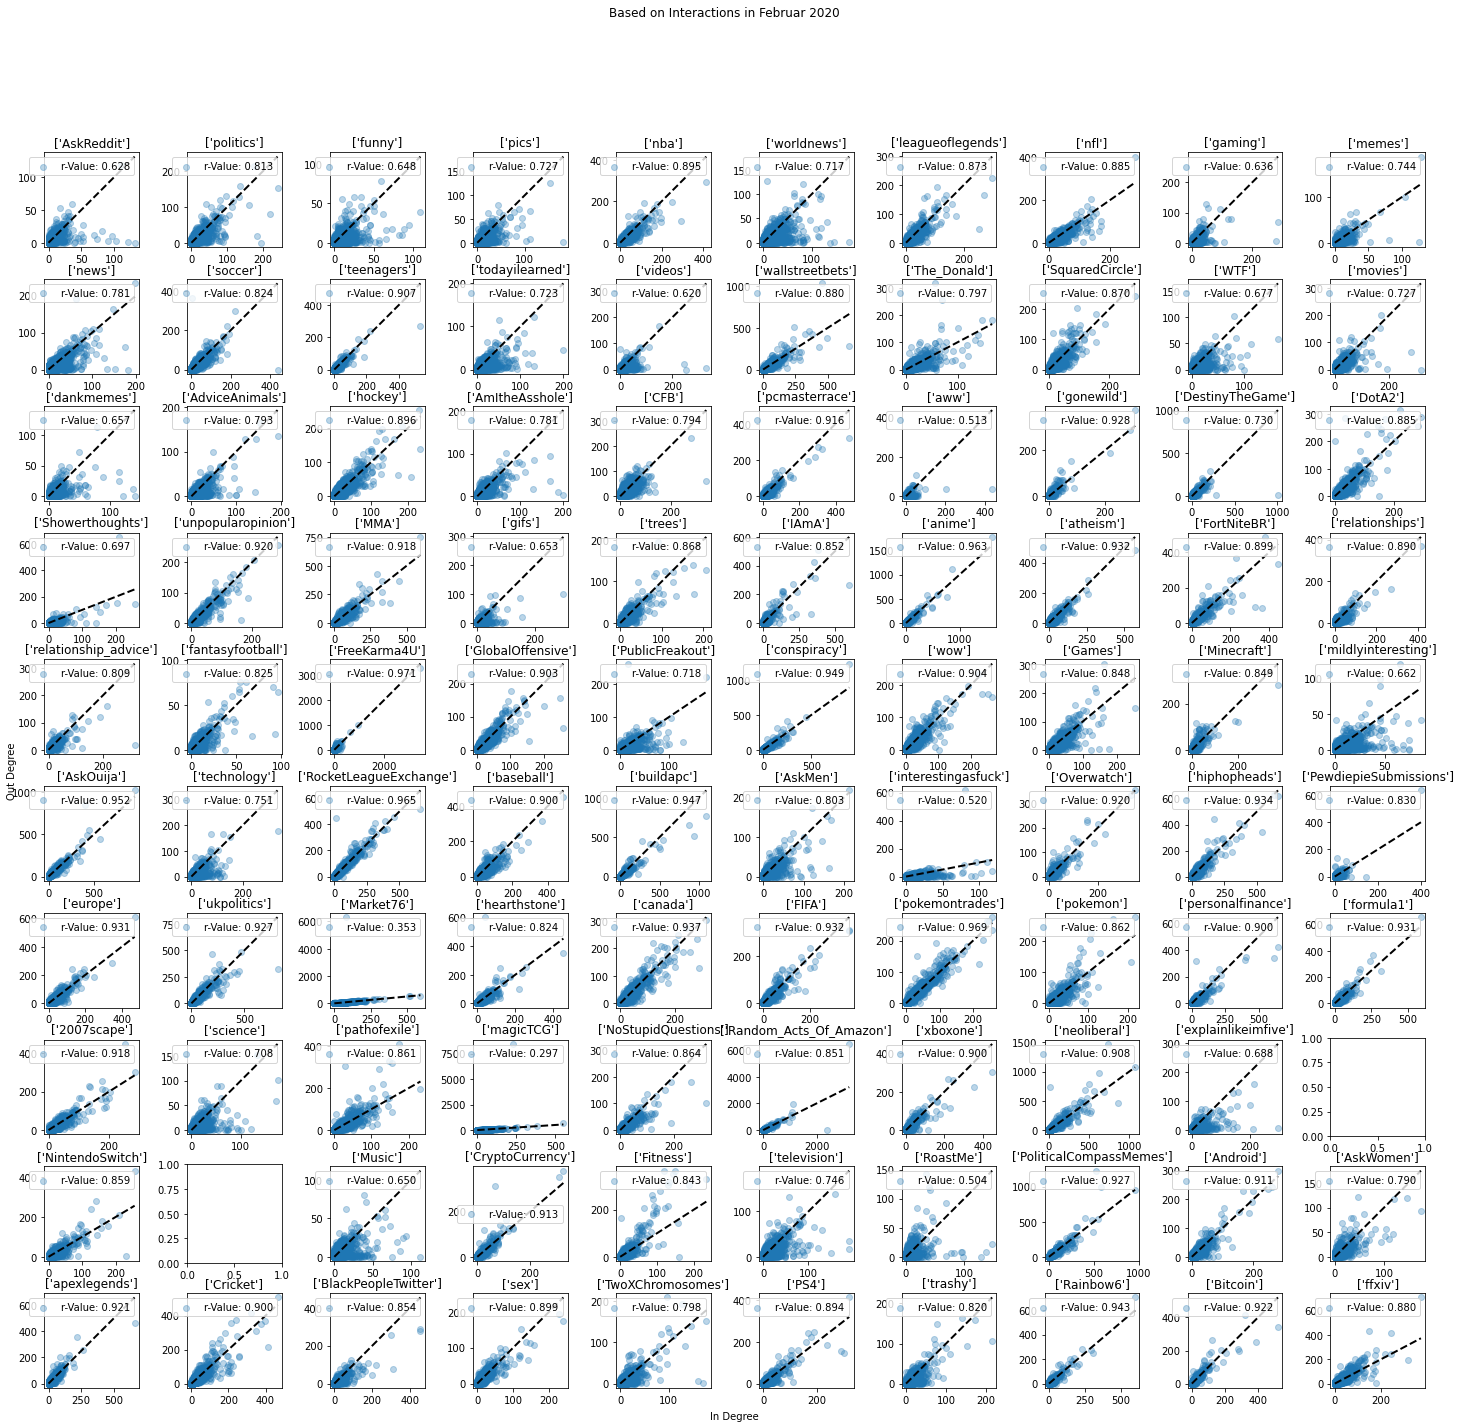

In [27]:
subreddits = getTop(100, 'comments') #topsubreddits[:,0]
fig, axis = plt.subplots(10,10)
fig.set_figheight(20)
fig.set_figwidth(20)
#clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
axis = axis.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in tqdm(enumerate(subreddits)):
    if subreddit != ['distantsocializing'] and subreddit != ['RedditSessions']:
        data = getData(db,subreddit.item(),start,end,'comments')
        G = genDirNet(data)
        in_degr = np.array(G.in_degree())[:,1]
        out_degr = np.array(G.out_degree())[:,1]
        dist = np.abs(in_degr-out_degr)
        ind = np.argpartition(dist, -3)[-3:]
        print('Subreddit: {}, Top 3 outlier authors: {}'.format(subreddit,data[ind,0]))
        plotting.plotdegrees(in_degr, out_degr, axis[idx], color='tab:blue', subreddit=subreddit)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
fig.suptitle('Based on Interactions in Februar 2020')

Subreddit not analyzed yet. Generating new array. This may take a while...


113033it [00:00, 210243.91it/s]


Subreddit not analyzed yet. Generating new array. This may take a while...


1964498it [00:10, 189889.08it/s]


Text(0, 0.5, 'PDF Triangles')

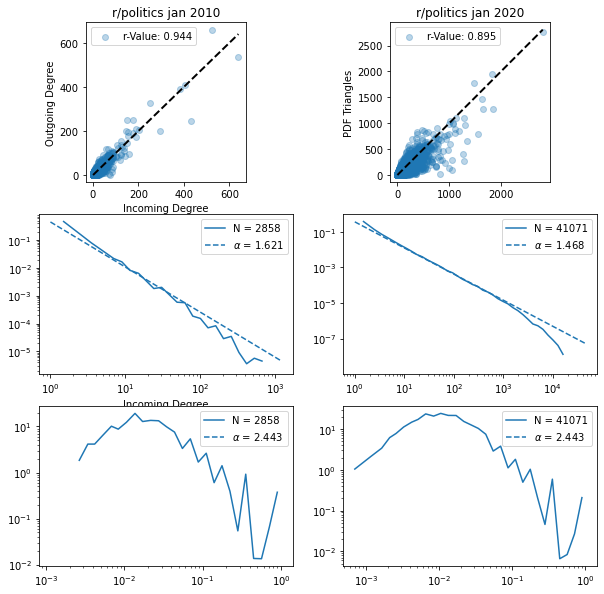

In [62]:
fig, axis = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(10)
start = getUTC(datetime.datetime(2010,1,1))
end = getUTC(datetime.datetime(2010,2,1))
data = getData(db,subreddit='politics',start=start,end=end,which='comments', save=False)
num_users = data.shape[0]
MultiG = nx.MultiDiGraph()
MultiG.add_nodes_from(np.arange(num_users))
for index, row in enumerate(data):
    if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
        MultiG.add_edge(int(row[3]),row[4])
in_degr = np.array(MultiG.in_degree())[:,1]
out_degr = np.array(MultiG.out_degree())[:,1]
plotting.plotdegrees(in_degr, out_degr, axis[0,0], color='tab:blue', title='r/politics jan 2010')
G = nx.Graph(MultiG)
triangles = np.array(list(nx.triangles(G).items()))[:,1]
clust = np.array(list(nx.clustering(G).items()))[:,1]
plotting.plotpowerlaw(triangles, axis[1,0],color='tab:blue',xmin=1)
plotting.plotpowerlaw(clust, axis[2,0], show_fit=True ,color='tab:blue')
del(G)
del(MultiG)
del(data)
    

start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,2,1))
newdata = getData(db,subreddit='politics',start=start,end=end,which='comments', save=False)
num_users = newdata.shape[0]
MultiG = nx.MultiDiGraph()
MultiG.add_nodes_from(np.arange(num_users))
for index, row in enumerate(newdata):
    if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
        MultiG.add_edge(int(row[3]),row[4])
in_degr = np.array(MultiG.in_degree())[:,1]
out_degr = np.array(MultiG.out_degree())[:,1]
plotting.plotdegrees(in_degr, out_degr, axis[0,1], color='tab:blue', title= 'r/politics jan 2020')
G = nx.Graph(MultiG)
triangles = np.array(list(nx.triangles(G).items()))[:,1]
clust = np.array(list(nx.clustering(G).items()))[:,1]
plotting.plotpowerlaw(triangles, axis[1,1],color='tab:blue',xmin=1)
plotting.plotpowerlaw(clust, axis[2,1], show_fit=True ,color='tab:blue')
axis[0,0].set_ylabel('Outgoing Degree')
axis[0,0].set_xlabel('Incoming Degree')
axis[1,0].set_xlabel('Incoming Degree')
axis[0,1].set_ylabel('PDF Triangles')

100it [01:40,  1.00s/it]


Text(0.5, 0.98, 'Number of Triangles. Based on Interactions in Februar 2020')

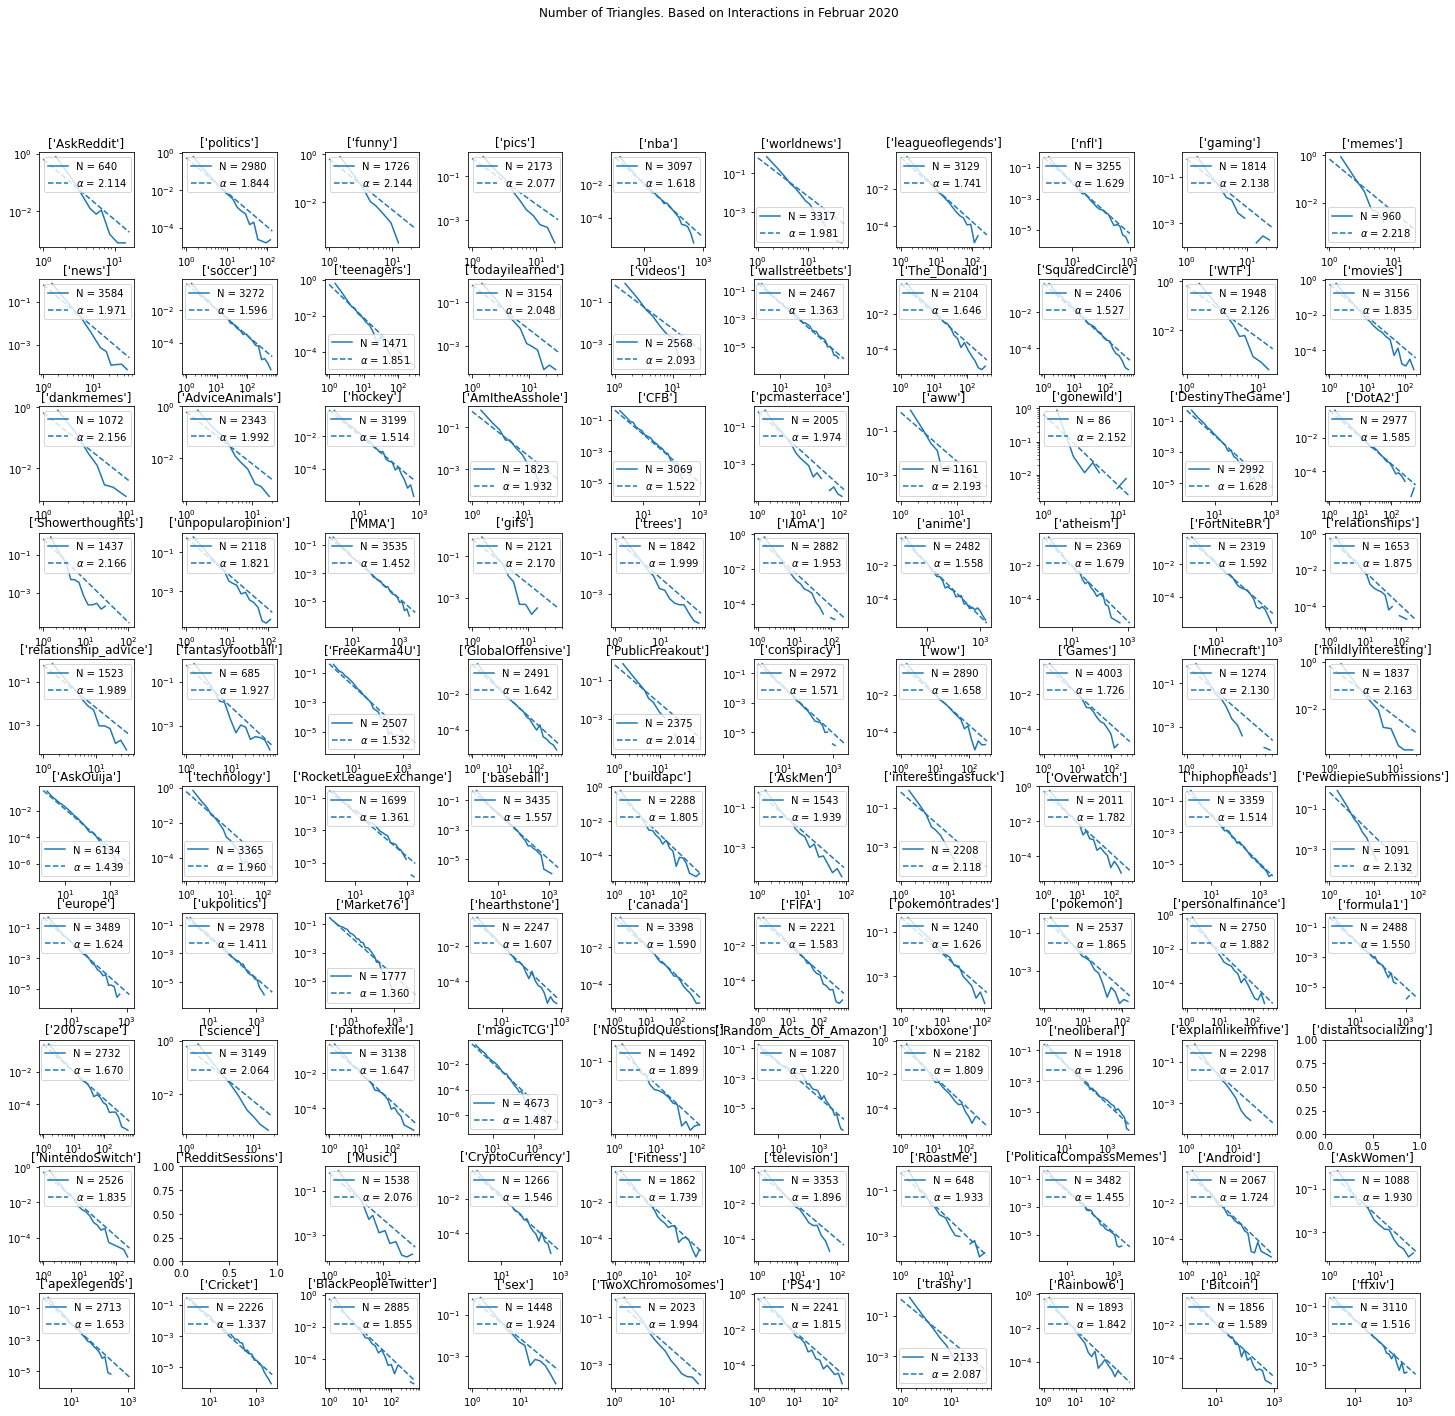

In [31]:
subreddits = getTop(100, 'comments')
fig, axis = plt.subplots(10,10)
fig.set_figheight(20)
fig.set_figwidth(20)
axis = axis.flatten()
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in tqdm(enumerate(subreddits)):
    if subreddit != ['distantsocializing'] and subreddit != ['RedditSessions']:
        data = getData(db,subreddit.item(),start,end,'comments')
        num_users = data.shape[0]
        G = nx.Graph()
        G.add_nodes_from(np.arange(num_users))
        for index, row in enumerate(data):
            if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
                G.add_edge(int(row[3]),row[4])
        G.remove_nodes_from(list(nx.isolates(G)))
        triangles = np.array(list(nx.triangles(G).items()))[:,1]
        #print('Subreddit: {}, avg. num of tri.:{}'.format(subreddit,triangles.mean()))
        plotting.plotpowerlaw(triangles, axis[idx],color='tab:blue',xmin=1)
    axis[idx].set_title(subreddit)
    axis[idx].set_box_aspect(1)
fig.suptitle('Number of Triangles. Based on Interactions in Februar 2020')

100it [01:45,  1.05s/it]


ValueError: x and y must be the same size

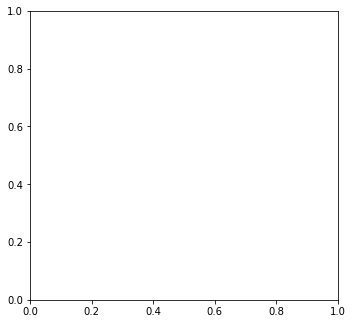

In [43]:
subreddits = getTop(100, 'comments')
fig, axis = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
avg_tri = []
for idx, subreddit in tqdm(enumerate(subreddits)):
    if subreddit != ['distantsocializing'] and subreddit != ['RedditSessions']:
        data = getData(db,subreddit.item(),start,end,'comments')
        num_users = data.shape[0]
        G = nx.Graph()
        G.add_nodes_from(np.arange(num_users))
        for index, row in enumerate(data):
            if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
                G.add_edge(int(row[3]),row[4])
        G.remove_nodes_from(list(nx.isolates(G)))
        triangles = np.array(list(nx.triangles(G).items()))[:,1]
        avg_tri.append(triangles.mean())
        #print('Subreddit: {}, avg. num of tri.:{}'.format(subreddit,triangles.mean()))
axis.scatter(getTopNum(98, 'comments')[:,1], avg_tri)
axis.set_box_aspect(1)

print(topsubreddits[np.argmax(avg_tri),0])



fig.suptitle('Number of Triangles. Based on Interactions in Februar 2020')

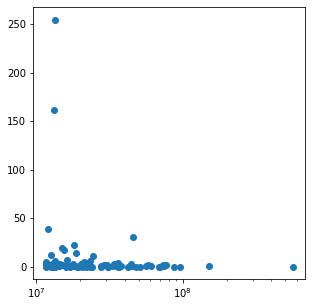

In [48]:
fig, axis = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
axis.scatter(getTopNum(98, 'comments')[:,1], avg_tri)
axis.set_xscale('log')
axis.set_box_aspect(1)

In [13]:
ind = np.argpartition(avg_tri, -10)[-10:]
print('Top 10 outlier subreddits: {}'.format(topsubreddits[ind,0]))

Top 10 outlier subreddits: ['buildapc' 'programming' 'Fitness' 'photography' 'nba' 'Bitcoin'
 'CryptoCurrency' 'wallstreetbets' 'anime' 'malefashionadvice']


99it [01:14,  1.33it/s]

malefashionadvice


Text(0.5, 0.98, 'Number of Triangles. Based on Interactions in Februar 2020')

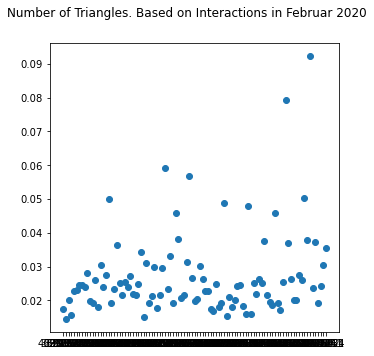

In [16]:
subreddits = topsubreddits[:,0]
fig, axis = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
avg_clust = []
for idx, subreddit in tqdm(enumerate(subreddits)):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    G.remove_nodes_from(list(nx.isolates(G)))
    clust = np.array(list(nx.clustering(G).items()))[:,1]
    avg_clust.append(clust.mean())
    #print('Subreddit: {}, Top 10 outlier authors: {}'.format(subreddit,topsubreddits[ind,0]))
    #print('Subreddit: {}, avg. num of tri.:{}'.format(subreddit,triangles.mean()))
print(topsubreddits[np.argmax(avg_clust),0])
axis.scatter(topsubreddits[:,1], avg_clust)
axis.set_box_aspect(1)
#axis.set_xscale('log')
fig.suptitle('Number of Triangles. Based on Interactions in Februar 2020')

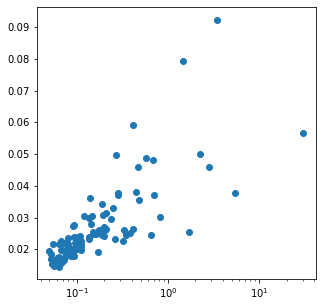

In [18]:
fig, axis = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
axis.scatter(avg_tri, avg_clust)
axis.set_xscale('log')

Subreddit: counting, Top 10 outlier authors: ['mistyskye14' 'Zaajdaeon' 'RandomMarimbist' 'timo78888' 'mistyskye14'
 'mistyskye14' 'colby6666' 'colby6666' 'llamasR5life' 'mistyskye14']
Subreddit: churning, Top 10 outlier authors: ['dennis_the_menace253' 'curiousgeorge498' 'RaulDukes' 'nalzuabi'
 'sl1pshade' 'churnchurnchurning' 'hythloth' 'LooseTone' 'shakesbusiness'
 'mikep4']
Subreddit: MachineLearning, Top 10 outlier authors: ['sinashish' 'ian_williamson' 'mongoosefist' 'i_love_FFT' 'DanielWicz'
 'anasuna' 'snowball_antrobus' 'Brainsonastick' 'AlleUndKalle'
 'local-minima']
Subreddit: washingtondc, Top 10 outlier authors: ['jaddiya' 'DistrictOfDeutsch' 'nam3backward5' 'klubkouture' 'WetDog2019'
 'FreemanCantJump' 'ohmygodlinda' 'scotch_please' 'smkAce0921' 'celj1234']
Subreddit: askscience, Top 10 outlier authors: ['Notonfoodstamps' 'bullerick' 'koalasonic' 'greygringo' 'redduif'
 'chickenbarf' 'AskScienceModerator' 'Juswantedtono' 'BiologyJ'
 'AutoModerator']
Subreddit: personalfin

Text(0.5, 0.98, 'Based on Interactions in Februar 2020')

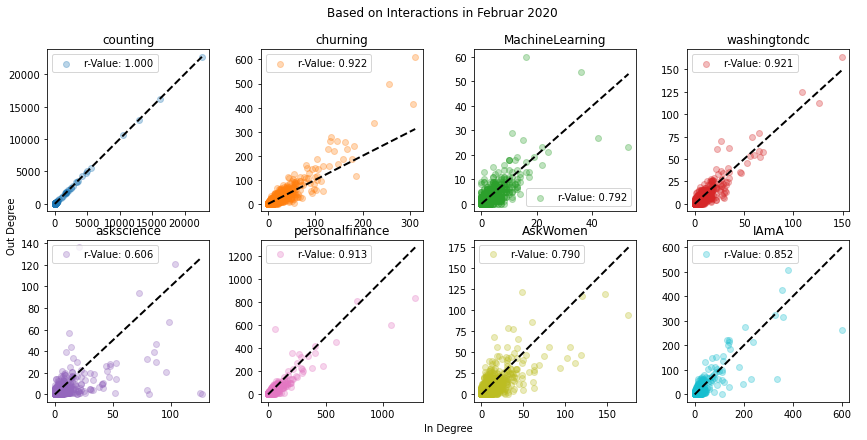

In [16]:
subreddits = ['counting', 'churning', 'MachineLearning', 'washingtondc', 'askscience', 'personalfinance', 'AskWomen', 'IAmA']#, 'AskMen']
fig, axis = plt.subplots(2,4)
fig.set_figheight(6)
fig.set_figwidth(12)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
axis = axis.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.MultiDiGraph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    in_degr = np.array(G.in_degree())[:,1]
    out_degr = np.array(G.out_degree())[:,1]
    dist = np.abs(in_degr-out_degr)
    ind = np.argpartition(dist, -10)[-10:]
    print('Subreddit: {}, Top 10 outlier authors: {}'.format(subreddit,data[ind,0]))
    plotting.plotdegrees(in_degr, out_degr, axis[idx], color=clr[idx], subreddit=subreddit)
    #del(data)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
fig.suptitle('Based on Interactions in Februar 2020')
#plt.savefig('InOutDegr.png',facecolor='white', transparent=False)

188274it [00:00, 236471.86it/s]


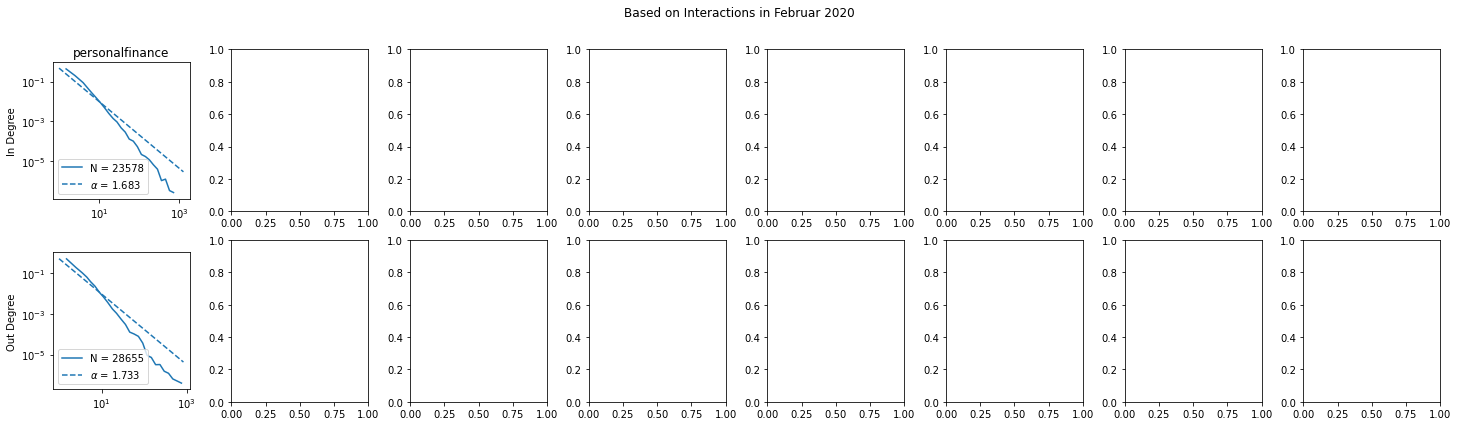

In [9]:
subreddits = ['personalfinance']#, 'counting', 'churning', 'MachineLearning', 'washingtondc', 'askscience', 'AskWomen', 'IAmA']
fig, axis = plt.subplots(2,8)
fig.set_figheight(6)
fig.set_figwidth(20)
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit,start,end,'comments')
    num_users = data.shape[0]
    G = nx.MultiDiGraph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in tqdm(enumerate(data)):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    in_degr = np.array(G.in_degree())[:,1]
    out_degr = np.array(G.out_degree())[:,1]
    plotting.plotpowerlaw(in_degr, axis[0,idx],color=clr[idx],xmin=1)
    plotting.plotpowerlaw(out_degr, axis[1,idx],color=clr[idx],xmin=1)
    axis[0,idx].set_title(subreddit)
    axis[0,idx].set_box_aspect(1)
    axis[1,idx].set_box_aspect(1)
axis[0,0].set_ylabel('In Degree')
axis[1,0].set_ylabel('Out Degree')
fig.suptitle('Based on Interactions in Februar 2020')
plt.savefig('InOutDegrHist.pdf')

Subreddit not analyzed yet. Generating new array. This may take a while...


6554it [00:00, 225951.36it/s]


Subreddit: desmoines, avg. clustering coeff.:0.0466872136487635
Subreddit: desmoines, avg. number of triangles:0.8397976391231029
Subreddit not analyzed yet. Generating new array. This may take a while...


15346it [00:00, 196702.53it/s]


Subreddit: MachineLearning, avg. clustering coeff.:0.04127844526137644
Subreddit: MachineLearning, avg. number of triangles:0.3685791528987684
Subreddit not analyzed yet. Generating new array. This may take a while...


31698it [00:00, 209873.11it/s]


Subreddit: washingtondc, avg. clustering coeff.:0.04810803643199203
Subreddit: washingtondc, avg. number of triangles:3.023733162283515
Subreddit not analyzed yet. Generating new array. This may take a while...


37047it [00:00, 210447.14it/s]


Subreddit: askscience, avg. clustering coeff.:0.02855376552271265
Subreddit: askscience, avg. number of triangles:0.16505230530802015
Subreddit not analyzed yet. Generating new array. This may take a while...


771816it [00:04, 189382.93it/s]


Subreddit: movies, avg. clustering coeff.:0.023479831033352057
Subreddit: movies, avg. number of triangles:1.6001095991911272
Subreddit not analyzed yet. Generating new array. This may take a while...


350568it [00:01, 205806.54it/s]


Subreddit: personalfinance, avg. clustering coeff.:0.04487912689650738
Subreddit: personalfinance, avg. number of triangles:1.0517503241340989
Subreddit not analyzed yet. Generating new array. This may take a while...


27111it [00:00, 216837.54it/s]


Subreddit: mylittlepony, avg. clustering coeff.:0.10415826038717432
Subreddit: mylittlepony, avg. number of triangles:7.784125075165364
Subreddit not analyzed yet. Generating new array. This may take a while...


189805it [00:01, 171420.08it/s]


Subreddit: AskWomen, avg. clustering coeff.:0.021071579779326204
Subreddit: AskWomen, avg. number of triangles:0.36142533936651583
Subreddit not analyzed yet. Generating new array. This may take a while...


116252it [00:00, 203547.43it/s]


Subreddit: IAmA, avg. clustering coeff.:0.04904969816423608
Subreddit: IAmA, avg. number of triangles:0.297065533789631
Subreddit not analyzed yet. Generating new array. This may take a while...


499498it [00:02, 212011.47it/s]


Subreddit: AskMen, avg. clustering coeff.:0.023607778249667935
Subreddit: AskMen, avg. number of triangles:0.9637088913216262


Text(0.5, 0.98, 'Clustering Coefficients. Based on Interactions in Februar 2020')

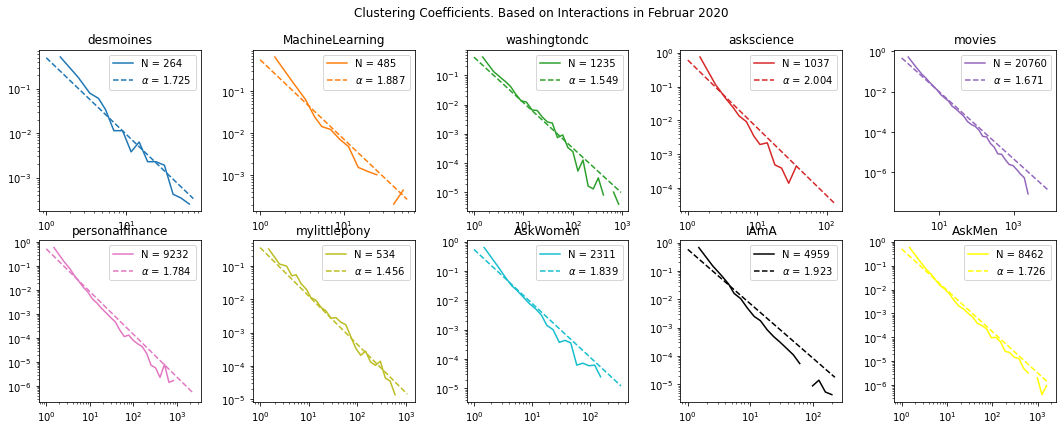

In [11]:
subreddits = ['desmoines', 'MachineLearning', 'washingtondc', 'askscience','movies', 'personalfinance','mylittlepony', 'AskWomen', 'IAmA', 'AskMen']#,# 'AskWomen', 'IAmA']
fig, axis = plt.subplots(2,5)
fig.set_figheight(6)
fig.set_figwidth(15)
axis = axis.flatten()
clr = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:pink','tab:olive','tab:cyan','black','yellow']
fig.tight_layout()
fig.subplots_adjust(top=0.88)
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,3,1))
for idx, subreddit in enumerate(subreddits):
    data = getData(db,subreddit=subreddit,start=start,end=end,which='comments', save=False)
    num_users = data.shape[0]
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_users))
    for index, row in enumerate(data):
        if row[4] != -1 and not math.isnan(row[4]) and not math.isnan(row[3]):
            G.add_edge(int(row[3]),row[4])
    G.remove_nodes_from(list(nx.isolates(G)))
    triangles = np.array(list(nx.triangles(G).items()))[:,1]
    clust = np.array(list(nx.clustering(G).items()))[:,1]
    print('Subreddit: {}, avg. clustering coeff.:{}'.format(subreddit,clust.mean()))
    print('Subreddit: {}, avg. number of triangles:{}'.format(subreddit,triangles.mean()))
    plotting.plotpowerlaw(triangles, axis[idx], show_fit=True ,color=clr[idx])
    axis[idx].set_title(subreddit)
    axis[idx].set_box_aspect(1)
    #axis[idx].set_xscale('linear')
    #axis[idx].set_yscale('linear')
fig.suptitle('Clustering Coefficients. Based on Interactions in Februar 2020')


In [ ]:

subreddit = 'desmoines'
data = pd.DataFrame(columns=['inDegr', 'outDegr', 'triangles'])
df =  pd.read_pickle('dataframes/{}_dataframe.pkl'.format(subreddit))
num_users = int(df['user_id'].max())+1
#data['user_id'] = df['user_id'].unique()
#Get in and out degree of each node from directed mulitgraph
diG = nx.MultiDiGraph()
diG.add_nodes_from(np.arange(num_users+1))
for index, row in tqdm(df.iterrows()):
    if row['link_user_id'] != -1 and not math.isnan(row['link_user_id']) and not math.isnan(row['user_id']):
        diG.add_edge(row['user_id'],row['link_user_id'])
#diG.remove_nodes_from(list(nx.isolates(diG)))
print(nx.isolates(diG))
print(np.array(diG.in_degree())[:,0][np.array(diG.in_degree())[:,1]>10])
in_degr = np.array(diG.in_degree())[:,1]
out_degr = np.array(diG.out_degree())[:,1]

data['inDegr'] = in_degr
data['outDegr'] = out_degr
del(diG)

G = nx.Graph()
G.add_nodes_from(np.arange(num_users+1))
for index, row in tqdm(df.iterrows()):
    if row['link_user_id'] != -1 and not math.isnan(row['link_user_id']) and not math.isnan(row['user_id']):
        G.add_edge(row['user_id'],row['link_user_id'])
#G.remove_nodes_from(list(nx.isolates(G)))
triangles = np.array(list(nx.triangles(G).items()))[:,1]

data['triangles'] = triangles


3725it [00:00, 13796.96it/s]


<generator object isolates.<locals>.<genexpr> at 0x00000254549C33C0>
[  12   15   26   33   34   60   77   94  105  112  114  126  140  154
  169  194  199  203  225  269  297  312  321  352  360  405  426  433
  435  440  463  480  485  493  498  502  503  528  535  538  548  566
  589  591  595  596  597  598  601  623  624  638  642  673  679  690
  691  705  716  746  775  802  846  854  856  877  881  883  895  916
  929  932  951  952  955  958  972  995 1009]


3725it [00:00, 14434.71it/s]


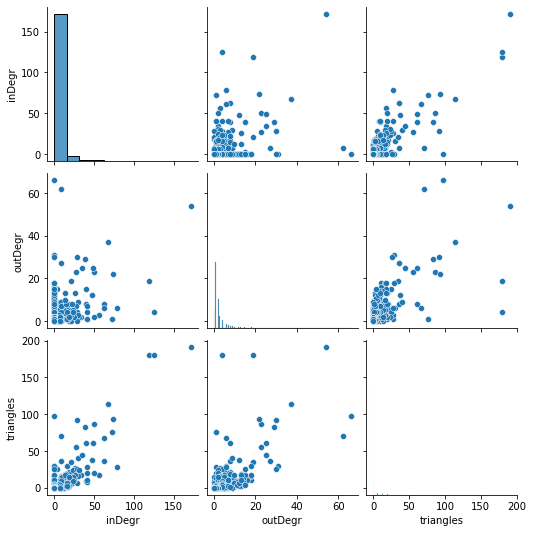

In [ ]:
sns.pairplot(data)

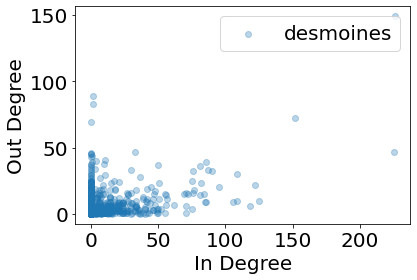

In [ ]:
plt.scatter(np.array(in_degr)[:,1],np.array(out_degr)[:,1], label = subreddit, alpha=0.3)
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
plt.legend()
plt.show()

26174


26174it [02:37, 165.99it/s]
100%|██████████| 13224/13224 [00:00<00:00, 528836.94it/s]
26484it [00:01, 20120.10it/s]


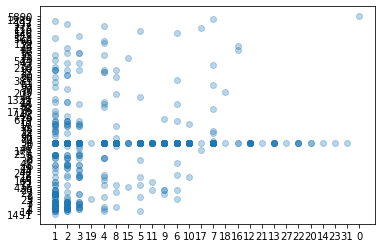

In [ ]:
subreddit = 'movies'
com_collection = db["comments"]
com_cursor = com_collection.aggregate(getPipeline(subreddit,start,end,False))
com_df = pd.DataFrame(list(com_cursor))
com_df = com_df.drop(columns=['subreddit','score', 'parent_id', '_id'])
sub_collection = db['submissions']
sub_cursor = sub_collection.aggregate(getPipeline(subreddit,start,end,True))
sub_df = pd.DataFrame(list(sub_cursor))
sub_df = sub_df.drop(columns=['subreddit','score','num_comments','domain', '_id'])

sub_df.insert(2, 'link_id', '')

df = pd.concat([sub_df,com_df])
#df['user_id'] = df.groupby('author').ngroup()
df['link_id'] = df['link_id'].astype('string').str.replace('t3_','')
#num_users = df['user_id'].max()+1
df['id'] = df['id'].astype('string') 
df['link_user'] = pd.Series(dtype=str)
df = df.assign(link_user = '')
df_dict = df.to_dict()
print(len(df['id']))
for i,li in tqdm(enumerate(df['link_id'])): #iterate over posts link id
    #link_user_id =  (df.loc[df['id'] == li, 'user_id']) #find the users id that corresponds to the link id
    #pos = df.loc[df['id'] == li].index
    user = df[df['id'] == li]['author']
    if (user.size > 0):
        df.at[i,'link_user'] = user.item()

G = nx.DiGraph()


for users in tqdm(df['author'].unique()): #iterate over posts link id
    G.add_node(users)

for index, row in tqdm(df.iterrows()):
    G.add_edge(row['link_user'],row['author'])
G.remove_nodes_from(list(nx.isolates(G)))
in_degr = np.array(G.in_degree())
out_degr = np.array(G.out_degree())

plt.scatter(np.sort(np.array(in_degr)[:,1]),np.sort(np.array(out_degr)[:,1]), label = subreddit, alpha=0.3)

In [ ]:
in_degr = np.array(G.in_degree())
out_degr = np.array(G.out_degree())
in_degr = np.delete(in_degr, (out_degr[:,1]).astype(int).argmax())
out_degr = np.delete(out_degr, (out_degr[:,1]).astype(int).argmax())
plt.scatter((in_degr[:,1]).astype(int),(out_degr[:,1]).astype(int), label = subreddit, alpha=0.3)
#plt.loglog()

['soldierofcinema' '1' 'PunnyBanana' ... '31' '' '0']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(np.sort(np.array(out_degr)[:,1]))

['0' '0' '0' ... '94' '96' '97']
